In [1]:
from qiskit import *
from qiskit.visualization import plot_bloch_multivector, plot_bloch_vector, plot_histogram

from qiskit.tools.monitor import job_monitor
from qiskit.providers.ibmq import least_busy

import matplotlib 
import numpy as np

%pylab inline

Populating the interactive namespace from numpy and matplotlib


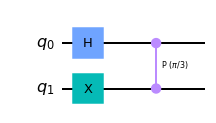

In [2]:
# for 2 qubits
qc2 = QuantumCircuit(2)
qc2.h(0)
qc2.x(1)
qc2.cp(pi/3, 1, 0)
qc2.draw('mpl')

In [3]:
#Statevector simuator

def statevector_sim(circuit):
    sv_sim = Aer.get_backend('statevector_simulator')
    qobj = assemble(circuit)
    out_vector = sv_sim.run(qobj).result().get_statevector()
    return out_vector

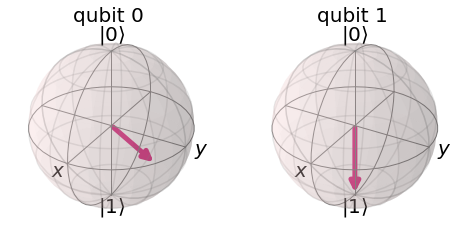

In [4]:
#Using Statevector simuator
out_vector = statevector_sim(qc2)
plot_bloch_multivector(out_vector)

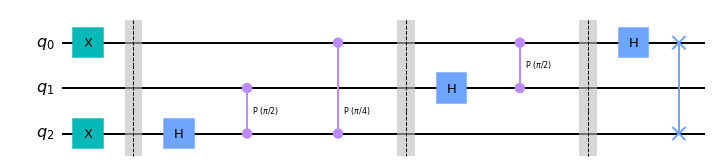

In [5]:
#for 3 qubits
qc3 = QuantumCircuit(3)
qc3.x((0,2))
qc3.barrier()

qc3.h(2)
qc3.cp(pi/2, 1, 2)
qc3.cp(pi/4, 0, 2)
qc3.barrier()

qc3.h(1)
qc3.cp(pi/2, 0, 1)
qc3.barrier()

qc3. h(0)
qc3.swap(0, 2)

qc3.draw('mpl')

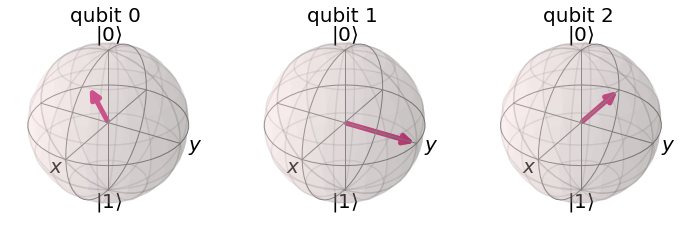

In [6]:
#Using Statevector simuator
out_vector = statevector_sim(qc3)
plot_bloch_multivector(out_vector)

In [7]:
#General case
def qft_rotations(qc, n):
    if n == 0:
        return qc
    
    n = n-1
    qc.h(n)
    for qubit in range(n):
        qc.cp(pi/(2**(n - qubit)), qubit, n)
    qc.barrier() 
    qft_rotations(qc, n)

In [8]:
def swap_registers(qc, n):
    for qubit in range(int(n/2)):
        qc.swap(qubit, n-qubit-1)

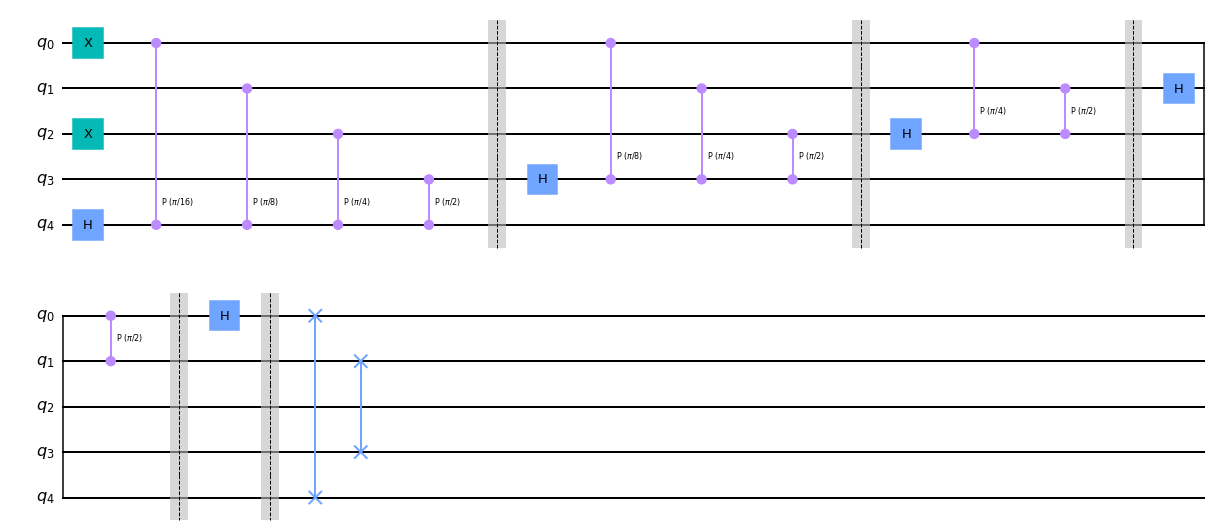

In [9]:
n = 5
qc = QuantumCircuit(n)
qc.x((0,2))
qft_rotations(qc, n)
swap_registers(qc, n)

qc.draw('mpl')

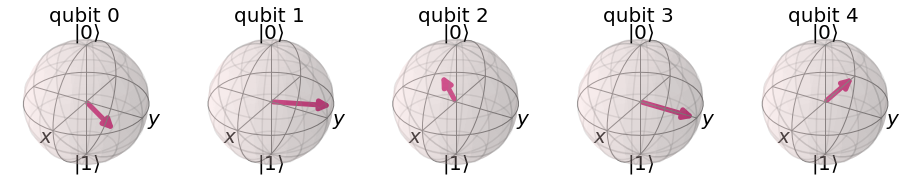

In [10]:
#Using Statevector simuator
out_vector = statevector_sim(qc)
plot_bloch_multivector(out_vector)

In [11]:
#Measurements on the states will collapse them onto a single state
#Inverse fourier transform can be performed by reversing order of gates

In [12]:
def qft(qc, n):
    qft_rotations(qc, n)
    swap_registers(qc, n)
    return qc

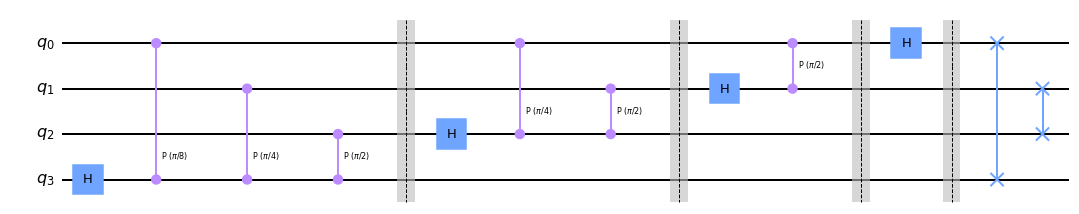

In [13]:
qc= QuantumCircuit(4)
qft(qc, 4)
qc.draw('mpl')

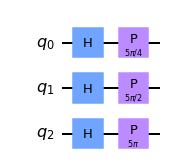

In [15]:
n = 3
num = 5
qc = QuantumCircuit(n)
for qubit in range (n):
    qc.h(qubit)
qc.p(num*pi/4, 0) 
qc.p(num*pi/2, 1) 
qc.p(num*pi, 2) 

qc.draw('mpl')

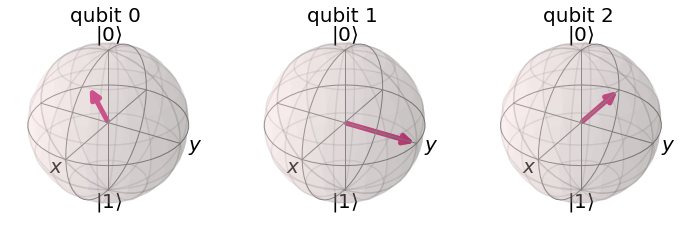

In [16]:
#Using Statevector simuator
out_vector = statevector_sim(qc)
plot_bloch_multivector(out_vector)

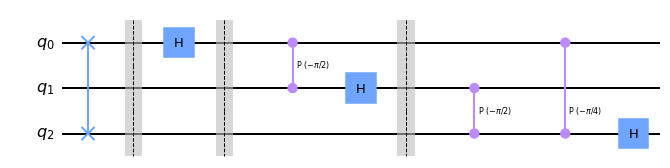

In [17]:
qft_cir = qft(QuantumCircuit(n), n)
invqft_circ = qft_cir.inverse()
display(invqft_circ.draw('mpl'))


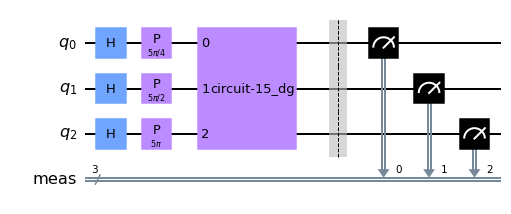

In [18]:
qc.append(invqft_circ, qc.qubits[:n])
qc.measure_all()
qc.draw('mpl')

In [19]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= n 
                                       and not x.configuration().simulator 
                                       and x.status().operational==True))
print("least busy backend: ", backend)

least busy backend:  ibmq_lima


In [20]:
shots = 2048
transpiled_qc = transpile(qc, backend, optimization_level=3)
qobj = assemble(transpiled_qc, shots=shots)
job = backend.run(qobj)
job_monitor(job)

<ipython-input-20-c72f574f7484>:4: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  job = backend.run(qobj)


Job Status: job has successfully run


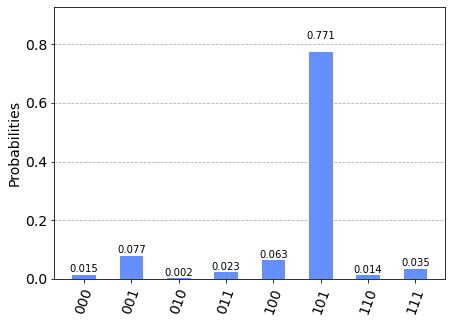

In [21]:
counts = job.result().get_counts()
plot_histogram(counts)